In [3]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, BertTokenizer
from torch.optim import AdamW
from ax.service.managed_loop import optimize
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from torch.nn import Dropout
from sklearn.model_selection import ParameterSampler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_traintest_dataset(group):
    # Load the arguments and labels into separate DataFrames
    df_arguments = pd.read_csv('arguments-'+group+'.tsv', delimiter='\t')
    df_labels = pd.read_csv('labels-'+group+'.tsv', delimiter='\t')

    # Merge the two DataFrames on the 'Argument ID' column
    df = pd.merge(df_arguments, df_labels, on='Argument ID')

    # Extract the argument text from each DataFrame
    id = df_arguments['Argument ID'].tolist()
    arguments = df_arguments['Premise'].tolist()
    stances = df_arguments['Stance'].tolist()
    conclusions = df_arguments['Conclusion'].tolist()

    return arguments, stances, conclusions, id, df, df_labels

labels_training = load_traintest_dataset("training")[5]
labels_test = load_traintest_dataset("test")[5]

# Load training dataset
arguments_training, stances_training, conclusions_training, id_training, df_training, df_labels = load_traintest_dataset("training")

In [3]:
# Preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text

In [4]:
def train_and_evaluate(test, training, columns, train_labels, test_labels):
    # Define the hyperparameters
    hyperparameters = {
        'learning_rate': [1e-5, 3e-5, 1e-4],
        'batch_size': [16, 32],
        'dropout_rate': [0.1, 0.2, 0.3]
    }

    # Initialize the random search
    random_search = ParameterSampler(hyperparameters, n_iter=10, random_state=0)

    best_f1 = 0
    best_model = None

    # Loop over each hyperparameter configuration
    for params in random_search:
        learning_rate = params['learning_rate']
        batch_size = params['batch_size']
        dropout_rate = params['dropout_rate']

        test_df = pd.read_csv(test, sep="\t")
        training_df = pd.read_csv(training, sep="\t")

        test_df['combined'] = test_df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
        training_df['combined'] = training_df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
        expanded_text_test = test_df['combined'].tolist()
        expanded_text_training = training_df['combined'].tolist()

        # Preprocess the text
        expanded_text_test_preprocessed = [preprocess_text(text) for text in expanded_text_test]
        expanded_text_training_preprocessed = [preprocess_text(text) for text in expanded_text_training]

        # Tokenize the texts
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        inputs_train = tokenizer(training_df['combined'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs_test = tokenizer(test_df['combined'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Create TensorDatasets
        dataset_train = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], torch.tensor(train_labels))
        dataset_test = TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], torch.tensor(test_labels))

        # Create DataLoaders
        dataloader_train = DataLoader(dataset_train, batch_size=batch_size)
        dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

        # Initialize the model and optimizer
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=20)  # For the 20 value labels
        model.to('cpu')
        optimizer = AdamW(model.parameters(), lr=learning_rate)
        # Add dropout 
        dropout = Dropout(dropout_rate)

        # Use BCEWithLogitsLoss for multi-label classification
        criterion = torch.nn.BCEWithLogitsLoss()

        # Train model
        for epoch in range(5):
            for batch in dataloader_train:
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to('cpu')
                attention_mask = attention_mask.to('cpu')
                labels = labels.to('cpu').float()
                outputs = model(input_ids, attention_mask=attention_mask)
                outputs = dropout(outputs.logits)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

        # Evaluate model
        model.eval()
        predictions = []
        true_labels = []
        for batch in dataloader_test:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to('cpu')
            attention_mask = attention_mask.to('cpu')
            labels = labels.to('cpu')
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.append(logits)
            true_labels.append(labels)

        predictions = torch.cat(predictions, dim=0)
        true_labels = torch.cat(true_labels, dim=0)

        # Calculate the metrics
        f1 = f1_score(true_labels.cpu(), predictions.cpu() > 0, average='samples')
        precision = precision_score(true_labels.cpu(), predictions.cpu() > 0, average='samples', zero_division=0)
        recall = recall_score(true_labels.cpu(), predictions.cpu() > 0, average='samples')

        # If the current model is better than the previous best model, update the best model
        if f1 > best_f1:
            best_f1 = f1
            best_model = model

    return best_model, best_f1, precision, recall, test_df['combined'].tolist()

# Load labels
labels_training = pd.read_csv("labels-training.tsv", sep="\t")
labels_test = pd.read_csv("labels-test.tsv", sep="\t")

# Convert labels to the correct format
labels_training_array = labels_training.drop('Argument ID', axis=1).values
labels_test_array = labels_test.drop('Argument ID', axis=1).values

In [5]:
# Train and evaluate the model on the original dataset
model_original, f1_original, precision_original, recall_original, expanded_text_test_preprocessed_original = train_and_evaluate("arguments-test.tsv", "arguments-training.tsv", ["Conclusion", "Stance", "Premise"], labels_training_array, labels_test_array)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are

KeyboardInterrupt: 

In [6]:
# Print the evaluation metrics for each model
print("Original dataset:")
print(f"F1 Score: {f1_original}")
print(f"Precision: {precision_original}")
print(f"Recall: {recall_original}")

Original dataset:
F1 Score: 0.5462076276797089
Precision: 0.6350888324873096
Recall: 0.36385439328015473


In [5]:
# Train and evaluate the model on the expanded dataset
model_expanded, f1_expanded, precision_expanded, recall_expanded, expanded_text_test_preprocessed_expanded = train_and_evaluate("HVD-expanded_dataset_test.tsv", "HVD-expanded_dataset_training.tsv", ["EXPANDED TEXT"], labels_training_array, labels_test_array)

print("Expanded dataset:")
print(f"F1 Score: {f1_expanded}")
print(f"Precision: {precision_expanded}")
print(f"Recall: {recall_expanded}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are

Expanded dataset:
F1 Score: 0.5310257670981021
Precision: 0.5586400169204737
Recall: 0.3723131194102006


In [5]:
# Train and evaluate the model on the expanded dataset with adjectives
model_expanded_adj, f1_expanded_adj, precision_expanded_adj, recall_expanded_adj, expanded_text_test_preprocessed_expanded_adj = train_and_evaluate("HVD-expanded_dataset_test.tsv", "HVD-expanded_dataset_training.tsv", ["EXPANDED TEXT ADJECTIVES"], labels_training_array, labels_test_array)

print("Expanded dataset with adjectives:")
print(f"F1 Score: {f1_expanded_adj}")
print(f"Precision: {precision_expanded_adj}")
print(f"Recall: {recall_expanded_adj}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are

Expanded dataset with adjectives:
F1 Score: 0.5322723032748413
Precision: 0.6042724196277496
Recall: 0.3270757795503989


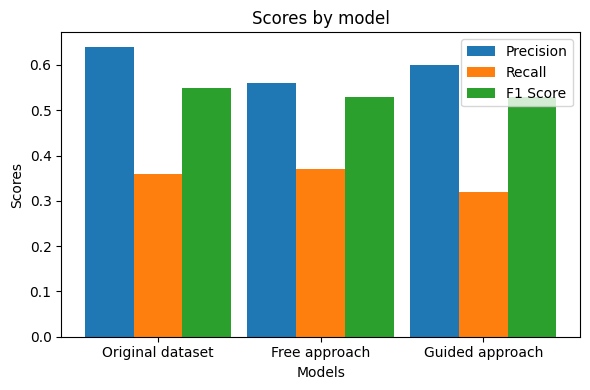

In [8]:
# Plot the metrics
models = ['Original dataset', 'Free approach', 'Guided approach']
precision_vals = [precision_original, precision_expanded, precision_expanded_adj]
recall_vals = [recall_original, recall_expanded, recall_expanded_adj]
f1_vals = [f1_original, f1_expanded, f1_expanded_adj]

x = np.arange(len(models)) 
width = 0.3
opacity = 0.8

fig, ax = plt.subplots(figsize=(6, 4))

rects1 = ax.bar(x - width, precision_vals, width, label='Precision')
rects2 = ax.bar(x, recall_vals, width, label='Recall')
rects3 = ax.bar(x + width, f1_vals, width, label='F1 Score')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Scores by model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()